In [ ]:
# quality check method ideas 
# 1) get max pixel brightness
# 2) fit gaussian to histogram of x and y axis of each star for size 
# 3) centroid location (to see if it's moving around)

In [1]:
from astropy.io import fits
from astropy.nddata import NDData
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from photutils.psf import extract_stars, EPSFBuilder
import pandas as pd
import numpy as np
from compare_aspect.plots import centile_clip
import matplotlib.pyplot as plt 
import sys 
sys.path.append('/home/bekah/gPhoton2')
sys.path.append('/home/ubuntu/gPhoton2/gPhoton')
from gPhoton.pipeline import execute_pipeline

12.04355
5.016494
4.017819
5.1069956
29.491388
6.1784344
812.5278
50.98702
5.2036767
12.369243
6.2235584
304.43735
9.351231
42.083416
16.29758
5.11847
18.845932
14.281703
7.2965837
27.589994
117.44248
51.039143
7.3636045
15.221446
9.507401


8.013035
4.0662017
3.0643492
6.057385
30.576916
4.0834527
703.7171
39.85564
6.191056
13.369057
9.274181
300.9336
13.481453
33.983555
12.178737
4.1797657
13.544266
13.294549
7.3005047
21.475344
99.01468
44.60757
10.506627
15.324864
12.671351


NameError: name 'x_data' is not defined

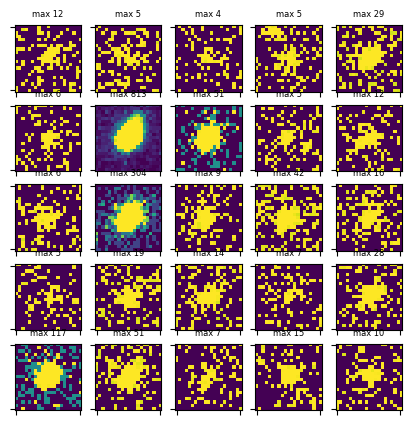

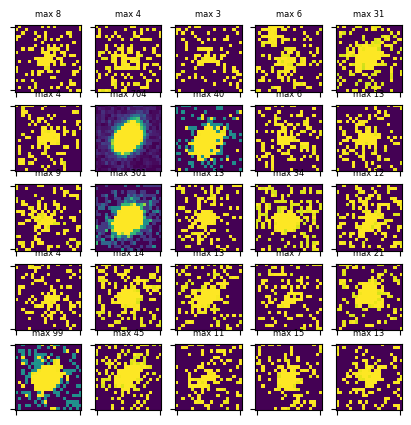

In [6]:
eclipse = 1696 
band = "NUV"
leg = 0
local_root = "/home/bekah/gPhoton2/"

og_folder = local_root + "og_asp_"+str(eclipse)
new_folder = local_root + "new_asp"+str(eclipse)

"""execute_pipeline(
        eclipse,
        band,
        depth=None,
        threads=4,
        local_root=new_folder,
        recreate=False,
        aperture_sizes=[12.8],
        write={"movie": False, "image": True},
        compression="rice",
        lil=True,
        burst=False,
        extended_photonlist=True,
        aspect="aspect2"
    ) """

files = get_file_names(eclipse, band, leg, og_folder, new_folder, local_root) 

new_comparison(files)

In [2]:
def new_comparison(file_names): 
    """ get list of cars"""
    global og_stars
    
    stars_tbl = get_good_stars(file_names)
    
    og_stars = cutout_stars(stars_tbl, file_names['old_image_file'])
    make_psf_plots(og_stars, file_names['star_cutouts'])
    
    # new stars cutout (same star locations)
    new_stars = cutout_stars(stars_tbl, file_names['new_image_file'])
    make_psf_plots(new_stars, file_names['star_cutouts_new'])
    
    psf_comparison_tab = pd.DataFrame()
    
    for x in range(int(len(stars_tbl)*.10)):
        og_result_tab = run_quality_check(og_stars[x].data)
        print(og_result_tab)
        og_max = get_max_pixel(og_stars[x].data)
        print(og_max)
        new_result_tab = run_quality_check(new_stars[x].data)
        print(new_result_tab)
        new_max = get_max_pixel(new_stars[x].data)
        print(new_max)
        

In [3]:
def get_file_names(eclipse, band, leg, og_folder, new_folder, root):
    """ image file names and photonlists """
    results = "/home/bekah/test_results/"
    file_names = {}
    eclipse_num = str(eclipse).zfill(5)
    eclipse_str = "e" + eclipse_num
    leg_str = str(leg).zfill(2)
    if band == "NUV":
        b = "nd"
    elif band == "FUV":
        b = "fd"
    og_folder = og_folder + "/" + eclipse_str + "/"
    new_folder = new_folder + "/" + eclipse_str + "/"
    file_names['old_image_file'] = og_folder + eclipse_str + f"-{b}-b{leg_str}-ffull-image-r.fits"
    file_names['new_image_file'] = new_folder + eclipse_str + f"-{b}-b{leg_str}-ffull-image-r.fits"
    # if aperture changes, 12_8 will change. could propagate up as a variable.
    file_names['old_photom_file'] = og_folder + eclipse_str + f"-{b}-b{leg_str}-" \
                                                              f"ffull-image-" \
                                                              f"photom-12_8.csv"
    file_names['old_aspect_parq'] = root+'gPhoton/aspect/aspect.parquet'
    file_names['aspect_parq'] = root+'gPhoton/aspect/aspect2.parquet'

    file_names['psf_comp'] = og_folder + eclipse_str + f"psf_comp.csv"
    file_names['image_comparison'] = og_folder + eclipse_str + "-image-compare.jpg"
    file_names['new_aspect'] = root + "test_data/aspect/" + eclipse_num + "_new_aspect.csv"
    file_names['star_cutouts'] = results + eclipse_str + "-star-cutouts.jpg"
    file_names['star_cutouts_new'] = results + eclipse_str + "-star-cutouts-newasp.jpg"

    return file_names

In [4]:
def get_good_stars(file_names):
    """get xy list of stars in astropy table, currently using
    gphoton2 main for star detection. """
    photom_table = pd.read_csv(file_names['old_photom_file'])
    
    # filtering for "good" stars 
    photom_table = photom_table[photom_table['flux'] > 5]
    photom_table = photom_table[photom_table['xcentroid'] > 550]
    photom_table = photom_table[photom_table['xcentroid'] < 2450]
    photom_table = photom_table[photom_table['ycentroid'] > 550]
    photom_table = photom_table[photom_table['ycentroid'] < 2450]
    photom_table = photom_table[photom_table['sharpness'] > .5]

    stars_tbl = Table()
    stars_tbl['x'] = photom_table['xcentroid']
    stars_tbl['y'] = photom_table['ycentroid']
    stars_tbl['flux'] = photom_table['flux']
    stars_tbl['dao_max_pix'] = photom_table['peak']
    
    return stars_tbl


def cutout_stars(stars_tbl, imagefile):
    """cutout stars from full-depth image using star table"""
    # open full depth image to clip it (imagefile can be old or new aspect
    # image file path)
    image = fits.open(imagefile)
    data = image[1].data
    # background subtraction
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.0)
    data -= median_val
    # change nans and inf to 0.0 for nddata purposes for psf fitting
    data = np.nan_to_num(data, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
    # The extract_stars() function requires the input data
    # as an NDData object.
    nddata = NDData(data=data)
    # extract stars, can be done on multiple images
    stars = extract_stars(nddata, stars_tbl, size=21)
    return stars


def make_psf_plots(stars, file):
    """plot 25 of the star cutouts used for the psf fitting"""
    import matplotlib.pyplot as plt
    nrows = 5
    ncols = 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5),
                           squeeze=True)
    ax = ax.ravel()
    for i in range(nrows * ncols): 
        print(stars[i])
        # currently only plotting the first 25 stars
        ax[i].imshow(centile_clip(stars[i], (0, 85)), 
                     origin='lower',
                     interpolation='none',
                     cmap='viridis')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        print(np.max(stars[i]))
        ax[i].set_title(f"max {round(np.max(stars[i].data))}", size=6)
    plt.savefig(file)
    return


In [5]:
def run_quality_check(star): 
    
    hist_x = get_histograms(star, 0)
    hist_y = get_histograms(star, 1)
    
    #plt.hist(hist_x)
    
    #plt.hist(hist_y)
    
    x_fit_x, y_fit_x, z_fit_x  = fit_gaussian(hist_x)
    x_fit_y, y_fit_y, z_fit_y = fit_gaussian(hist_y)

    max_pix = get_max_pixel(star)
    
    quality_info = {"x_fit_x": x_fit_x,
                    "y_fit_x": y_fit_x,
                    "z_fit_x": z_fit_x,
                   "x_fit_y": x_fit_y, 
                    "y_fit_y": y_fit_y, 
                    "z_fit_y": z_fit_y
                   }
    
    return quality_info 


def get_histograms(star, ax): 
    import numpy as np

    hist = np.sum(star, axis=ax)
    
    #plt.hist(hist)

    return hist 


def fit_gaussian(hist): 
    
    from scipy.optimize import curve_fit

    initial_guess = (1, np.mean(x_data), np.mean(y_data), 1, 1, 0, 0)

    popt, _ = curve_fit(gaussian_2d, (x_edges[:-1], y_edges[:-1]), hist.ravel(), p0=initial_guess)
    
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = np.linspace(min(y_data), max(y_data), 100)
    x_fit, y_fit = np.meshgrid(x_fit, y_fit)
    z_fit = gaussian_2d((x_fit, y_fit), *popt)
    
    return x_fit, y_fit, z_fit 


def get_max_pixel(star): 
    import numpy as np
    max_pix = numpy.max(star)
    return max_pix 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / (2 * stddev))**2)

initial_guess = [1, 0, 1]  # initial values for amplitude, mean, and standard deviation
params, covariance = curve_fit(gaussian, x, y_noisy, p0=initial_guess)

# Plot the original data and the fitted Gaussian
plt.plot(x, y_noisy, 'bo', label='Noisy Data')
plt.plot(x, gaussian(x, *params), 'r-', label='Fitted Gaussian')
plt.legend()
plt.title('Fit Gaussian to 1D Array')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print("Fitted parameters (amplitude, mean, stddev):", params)


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sample data (replace this with your actual data)
data = np.random.normal(loc=0, scale=1, size=1000)

# Create histogram
hist, bin_edges = np.histogram(data, bins=50, density=True)

# Define Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 2 / stddev)**2)

# Initial guess for the parameters
initial_params = [1.0, 0.0, 1.0]

# Fit the Gaussian function to the histogram data
params, covariance = curve_fit(gaussian, bin_edges[:-1], hist, p0=initial_params)

# Extract standard deviation (width) from the parameters
width = 2 * np.abs(params[2])  # Factor of 2 to convert from FWHM to standard deviation

print("Width of Gaussian fit:", width)

# Plot the histogram and the Gaussian fit
plt.hist(data, bins=50, density=True, alpha=0.7, label='Histogram')
plt.plot(bin_edges[:-1], gaussian(bin_edges[:-1], *params), 'r--', label='Gaussian Fit')
plt.legend()
plt.show()


In [ ]:
def gaussian_2d((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = x - xo, y - yo
    a = np.cos(theta)**2 / (2 * sigma_x**2) + np.sin(theta)**2 / (2 * sigma_y**2)
    b = -np.sin(2 * theta) / (4 * sigma_x**2) + np.sin(2 * theta) / (4 * sigma_y**2)
    c = np.sin(theta)**2 / (2 * sigma_x**2) + np.cos(theta)**2 / (2 * sigma_y**2)
    return offset + amplitude * np.exp(-(a * x**2 + 2 * b * x * y + c * y**2))

